# Урок 4. Семантическая Сегментация
## Домашнее задание  
__Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow].__

## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [1]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import pycocotools

In [ ]:
!rm -r data

rm: cannot remove 'data': No such file or directory


## Загрузка датасета COCO и COCO API

In [2]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2022-10-01 09:43:10--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.68.60
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.68.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  12.9MB/s    in 28m 54s 

2022-10-01 10:12:05 (10.6 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-10-01 10:12:05--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.230.241
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.230.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  12.4MB/s    in 65s     

2022-10-01 10:13:10 (12.0 MB/s) - ‘v

In [3]:
!cd data && rm train2017.zip
!cd data && rm val2017.zip

## Подготовка COCO API

In [4]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Оптимизация датасета
~~В целях слижения времени обучения возьмем 20% от количества объектов сета~~  
~~В датасете COCO 90 категорий изображений. Для обучения нейросети требуется только `person`. Изменить размер сета можно внеся исправления в файл `instances_train2017.json` с помощью [COCO Manager](https://github.com/immersive-limit/coco-manager "COCO Manager"), либо используя средства библиотеки `pycocotools`~~

In [ ]:
# !python filter.py --input_json C:\...\GB_DataScience-in-Med\15_DL_in_computer_vision\data\annotations\instances_train2017.json --output_json C:\...\GB_DataScience-in-Med\15_DL_in_computer_vision\data\annotations\filtered.json --categories person

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cd data && unzip -q train2017.zip
# !cd data && unzip -q val2017.zip

In [34]:
# чтение категорий в датасете
dataDir='./data'
dataType='val'
annFile='{}/annotations/instances_{}2017.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

for line in cats:
    print(line)

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
{'supercategory': 'person', 'id': 1, 'name': 'person'}
{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}
{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
{'supercategory': 'vehicle', 'id': 7, 'name': 'train'}
{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}
{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}
{'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}
{'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}
{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}
{'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}
{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}
{'supercategory': 'animal', 'id': 16, 'name': 'bird'}
{'supercategory': 'animal', 'id': 17, 'name': 'cat'}
{'s

In [ ]:
# вывод случайного изображения из категории
# Define the classes (out of the 90) which you want to see. Others will not be shown.
filterClasses = ['person']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/{}2017/{}'.format(dataDir,dataType,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

## Универсальный класс Dataset для сегментации

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

## Визуализация данных

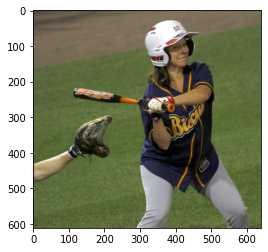

In [7]:
img = io.imread('data/train2017/000000026602.jpg')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

## Создание модели U-Net

In [8]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

## Визуализация модели U-Net

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

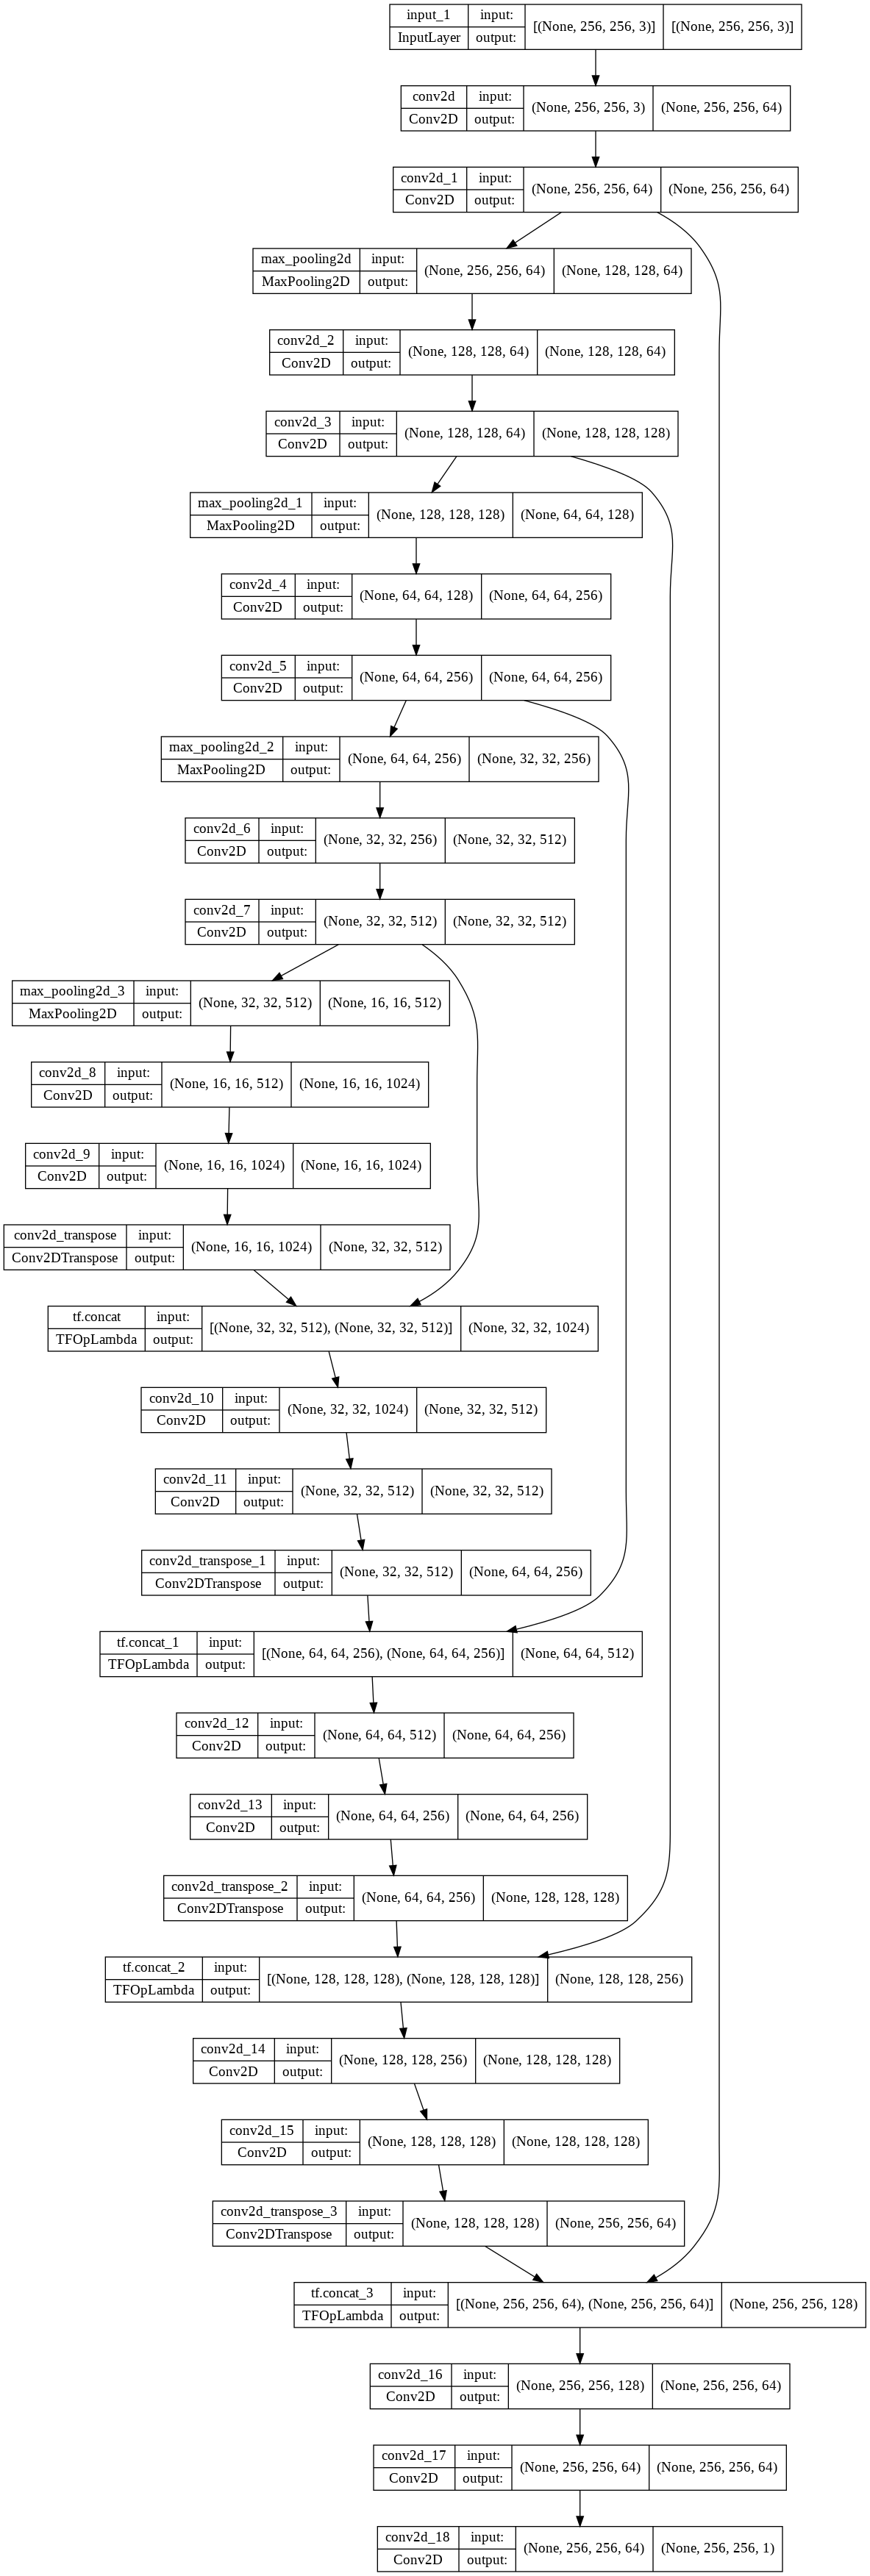

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Обучение модели

In [ ]:
# COCO_dataset_train = COCO_Dataset('train', 0.7)
# COCO_dataset_val = COCO_Dataset('val', 0.7)

In [11]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=22.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [16]:
INP_SIZE = 256
NUM_EPOCHS = 1
BATCH_SIZE = 32

In [17]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

In [18]:
LEARNING_RATE = 0.0003

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [19]:
%%time

hist = model.fit(train_ds)

# plt.plot(hist.history['loss'])

2003/2003 [==============================] - 4209s 2s/step - loss: 0.3846 - accuracy: 0.8201
CPU times: user 51min 20s, sys: 1min 59s, total: 53min 19s
Wall time: 1h 10min 9s


In [20]:
model.evaluate(val_ds)

84/84 [==============================] - 88s 1s/step - loss: 0.3402 - accuracy: 0.8417


[0.34016117453575134, 0.8417201042175293]

In [21]:
prediction = model.predict(val_ds)

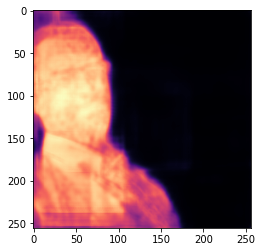

In [33]:
plt.imshow(prediction[362].reshape(256, 256), cmap='magma')
plt.show()

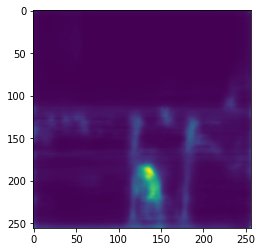

In [31]:
plt.imshow(prediction[182].reshape(256, 256))
plt.show()